In [141]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from constants import DATA_CLASSES
import sys

In [142]:
BATCH_SIZE = 32
CLASS_COUNT = 43
INPUT_IMAGE_SIZE = (64, 64)

In [143]:
# Get testing data
directory = '../data/recognition'
df = pd.read_csv(os.path.join(directory, 'Test.csv'))


paths = df['Path'].values
# paths = paths.map(lambda x: os.path.join(directory, x))
# paths = tf.constant(paths, dtype=tf.string)
labels = df['ClassId'].values


test_data = tf.data.Dataset.from_tensor_slices((paths, labels))

def read_image(image_path, label):
    image = tf.io.read_file(directory + "/" + image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, (INPUT_IMAGE_SIZE[0], INPUT_IMAGE_SIZE[1]))
    
    return image/255, label

test_data = test_data.map(read_image).batch(BATCH_SIZE, drop_remainder=True).shuffle(100, reshuffle_each_iteration=True)

In [144]:
# Load a model
model = load_model(os.path.join('..', 'models', 'recognition', 'trafficsignrecognizer07.h5'))

In [145]:
# Metrics
precision = Precision()
recall = Recall()
accuracy = Accuracy()

# Calculate metrics
# results = model.evaluate(test_data, batch_size=128)

TEST_BATCH_COUNT = len(test_data) # all batches

# Metrics for accuracy history graph
batch_accuracies = []

# Metrics for confusion matrix
y_trues = []
y_preds = []

batches = []
for bidx, batch in enumerate(test_data.take(TEST_BATCH_COUNT).as_numpy_iterator()):
    current_batch_number = bidx + 1
    sys.stdout.write(f"\rEvaluating batch {current_batch_number}/{TEST_BATCH_COUNT} - {round(current_batch_number/TEST_BATCH_COUNT * 100, 2)}%")
    sys.stdout.flush()  
    x, y = batch
    
    
    pred = model.predict(x, verbose=0)
    correct_in_batch_count = 0
    for idx, p in enumerate(pred):
        lblidx = np.argmax(p)
        if lblidx == y[idx]:
            correct_in_batch_count += 1
            
    
    batch_accuracies.append(correct_in_batch_count / BATCH_SIZE)
            
    pred_parsed = list(map(lambda x: x.argmax(), pred))
    batches.append((pred_parsed, y))
    y_preds.extend(pred_parsed)
    y_trues.extend(y)
    
    precision.update_state(y, pred_parsed)
    recall.update_state(y, pred_parsed)
    accuracy.update_state(y, pred_parsed)

f1 = f1_score(y_trues, y_preds, average='macro')

Evaluating batch 394/394 - 100.0%

In [147]:
# Print metrics
print(f'Precision: {round(float(precision.result().numpy()), 2)}, Recall: {round(float(recall.result().numpy()), 2)}, Accuracy: {round(float(accuracy.result().numpy()), 4)}, F1 Score: {round(f1, 4)}')

Precision: 1.0, Recall: 1.0, Accuracy: 0.9221, F1 Score: 0.8934


Lowest accuracy: 0.78125 (batch 18), highest accuracy: 1.0 (batch 9)

Most confused classes:
Speed limit (120km/h) - Speed limit (80km/h)
Beware of ice/snow - Children crossing
Double curve - Road work
Right-of-way at intersection - Road work
Speed limit (120km/h) - Speed limit (100km/h)
Turn left ahead - Ahead only
Speed limit (120km/h) - Speed limit (100km/h)


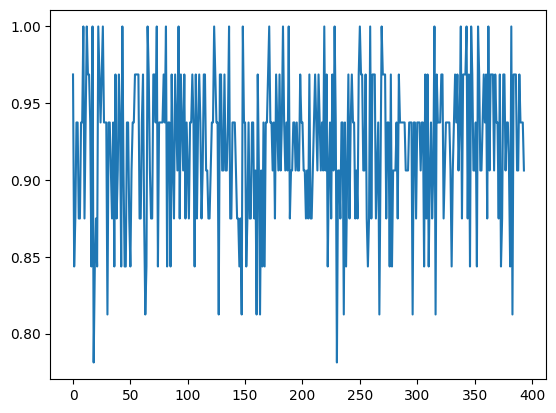

In [148]:
# Plot accuracy
lowest = min(batch_accuracies)
highest = max(batch_accuracies)
print(f'Lowest accuracy: {lowest} (batch {batch_accuracies.index(lowest)}), highest accuracy: {highest} (batch {batch_accuracies.index(highest)})')
_ = plt.plot(batch_accuracies)

print("\nMost confused classes:")

for p, t in zip(batches[batch_accuracies.index(lowest)][0], batches[batch_accuracies.index(lowest)][1]):
    if p != t:
        print(f'{DATA_CLASSES[p]} - {DATA_CLASSES[t]}')

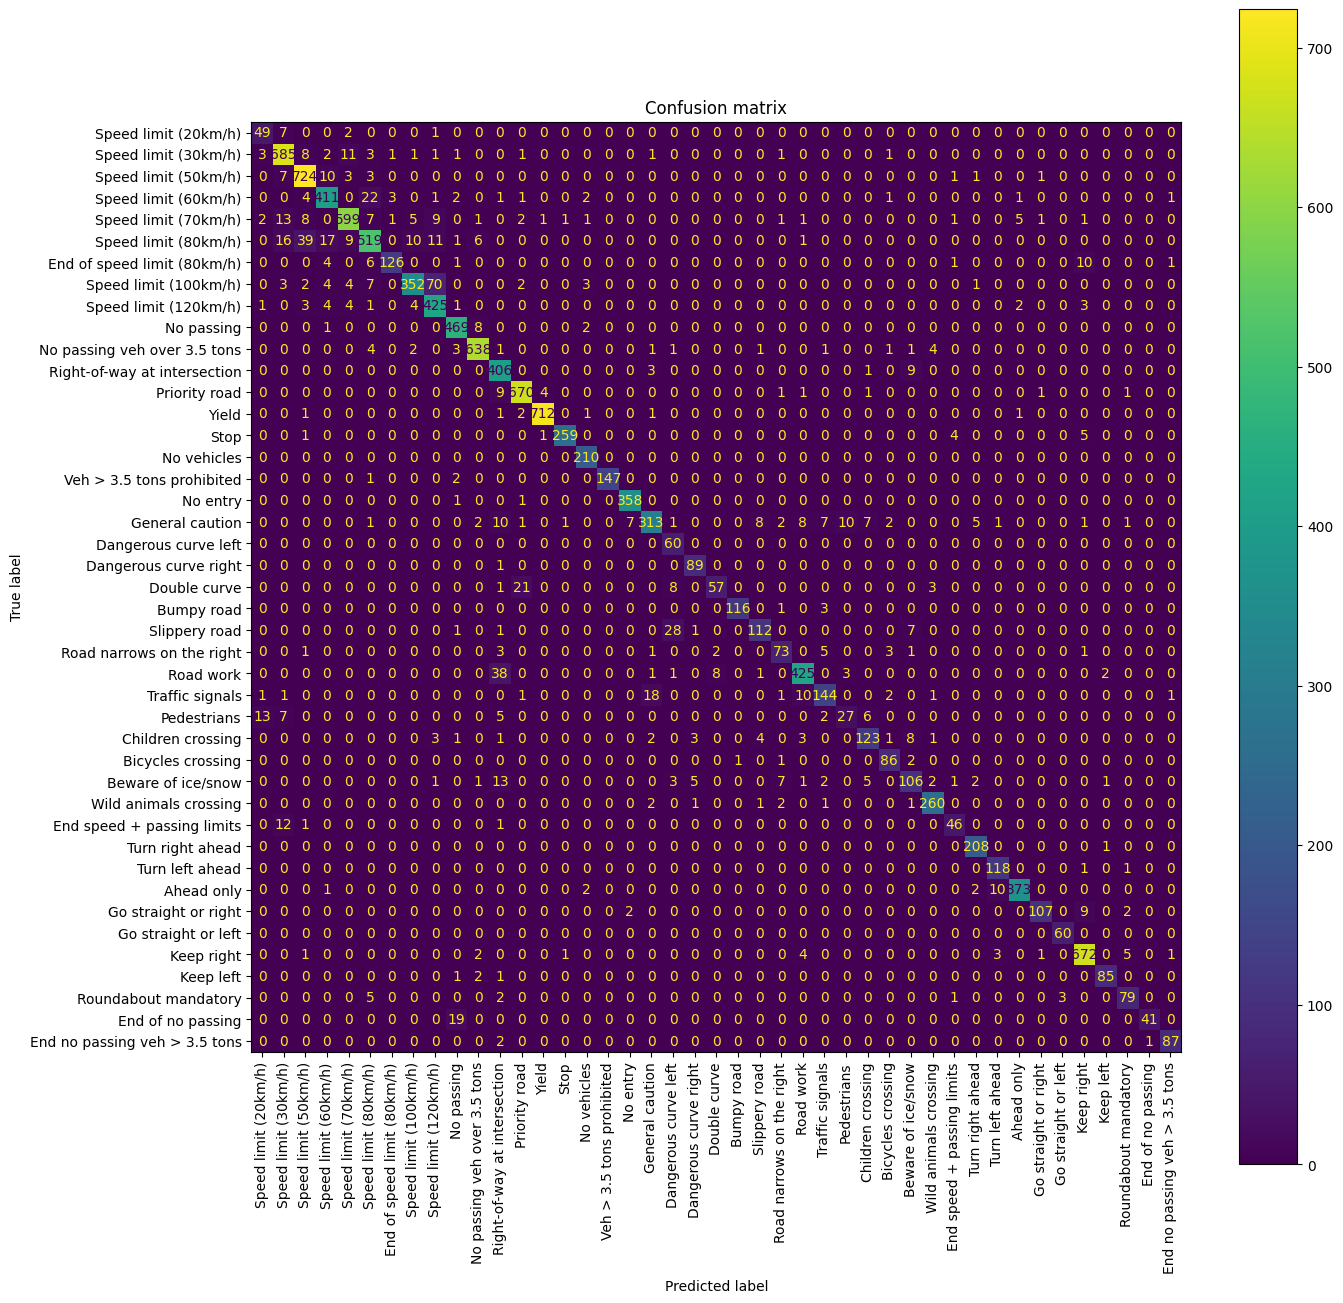

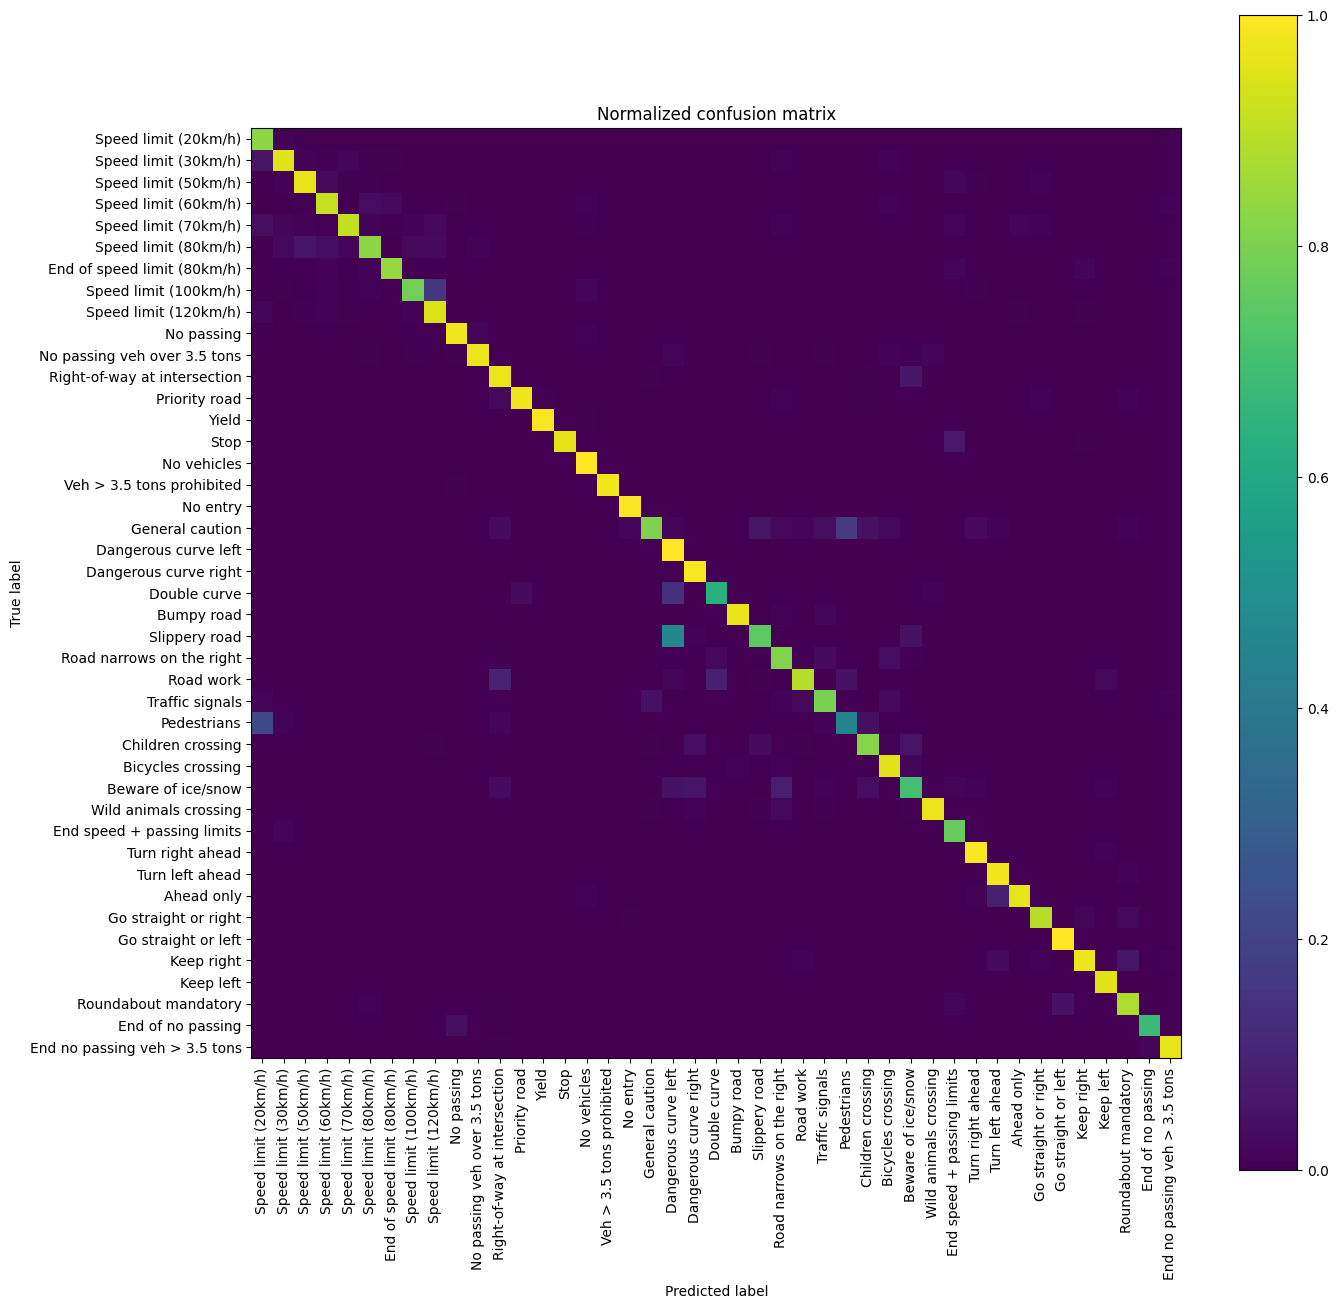

In [149]:
# Plot confusion matrix
cm = confusion_matrix(y_trues, y_preds, labels=list(DATA_CLASSES.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(DATA_CLASSES.values()))

fig, ax = plt.subplots(figsize=(15,15))
plt.title("Confusion matrix")
_ = disp.plot(ax=ax, xticks_rotation='vertical')

# Normalize
ncm = cm.astype('float') / cm.sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm, display_labels=list(DATA_CLASSES.values()))

fig, ax = plt.subplots(figsize=(15,15))
plt.title("Normalized confusion matrix")
_ = disp.plot(ax=ax, xticks_rotation='vertical', include_values=False)